# Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
keyword = list()
for i in range(33, 127):
    keyword.append(i)

# Personal Information

In [3]:
import csv

header = ['first_name', 'last_name', 'age', 'birth_year', 'country', 'state',
          'city', 'address', 'highschool', 'university', 'phone', 'father',
          'mother', 'email', 'username', 'zipcode', 'credit_card']

data = [
        {
         'first_name': 'Tonya',
         'last_name': 'Watkins',
         'age': '31',
         'birth_year': '1990',
         'country': 'USA',
         'state': 'LA',
         'city': 'Lake Charles',
         'address': '2003 Willow Oaks Lane',
         'highschool': 'Lowell High School',
         'university': 'UC Irvine',
         'phone': '337-338-6860',
         'father': 'Thomas',
         'mother': 'Jane',
         'email': 'TonyaFWatkins@gmail.com',
         'username': 'Wiffor1990',
         'zipcode': '70601',
         'credit_card': '5330 2256 5617 0654'
        }
]


with open('personal_information.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    writer.writerows(data)

# Neural Network

## Activation Function

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    a = sigmoid(x) #1 / (1 + np.exp(-x))
    return a*(1-a) 


def relu(x):
    return np.maximum(0,x)

## Input cannot be a list, it has to be either a number or a numpy array. 
def d_relu(x):
    return x>0

def leaky_relu(x):
    return np.maximum(0.01*x ,x)

## Input cannot be a list, it has to be either a number or a numpy array. 
def d_leaky_relu(x):
    return (x>0) + .01*(x<0)


def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1-np.tanh(x)**2

## Random Network Generator

In [5]:
def random_network_generator( nl_list ):
    w_list = []
    b_list = []
    for i in range(len(nl_list)-1 ):
        w_list += [ np.random.uniform(-1,1,size=[nl_list[i+1] , nl_list[i] ]) ]
        b_list += [ np.random.uniform(-1,1,size=[ nl_list[i+1], 1 ]) ]
    return w_list, b_list

## Loss Function

In [6]:
def LOSS(a):
    information = pd.read_csv('personal_information.csv')
    information = information.values[0]
    distance = 0
    S = str()
    for i in range(len(a[0])):
        a[0][i] = (a[0][i] - min(a[0])) / (max(a[0]) - min(a[0])) * (max(keyword) - min(keyword)) + min(keyword)
        S = S + (chr(int(a[0][i]*len(keyword) + min(keyword))))
    for feature in range(len(information)):  
        distance -= int(str(information[feature]).lower() in S.lower())
    for i in range(len(Y)):
        for j in range(len(Y)):
            if i != j and Y.lower()[i] == Y.lower()[j]:
                distance -= 1
    return distance

## Feed-forward

In [7]:
def single_layer(x, w, b ,  activation_func=(lambda x: leaky_relu(x)  ) ):
    z = np.dot( w, x) + b
    return z , activation_func( z )

def NN_forward(x, w_list, b_list, activation_func_list=[(lambda x: leaky_relu(x))]  ):
    a = x
    z_list = []
    a_list = [a]
    if len(activation_func_list) == 1: 
        for i in range(len(w_list)):
            z, a = single_layer(a , w_list[i], b_list[i] , activation_func_list[0] )
            z_list += [ z ]
            a_list += [ a ]
    else:                           
        for i in range(len(w_list)):
            z, a = single_layer(a , w_list[i], b_list[i] , activation_func_list[i] )
            z_list += [ z ]
            a_list += [ a ]
      
    return a_list, z_list
  

def NN_func(w_list, b_list,  activation_func_list=[(lambda x: leaky_relu(x)) ] ):
    def func(x):
        return NN_forward(x, w_list, b_list, activation_func_list)
    return(func)

In [8]:
nl_list = [len(keyword), 10, 1]
ws, bs = random_network_generator(nl_list)

nn_f = NN_func(ws, bs , activation_func_list=[(lambda x: leaky_relu(x) )] )

## Key Generation (v.1)

In [9]:
X = keyword
for i in range(len(keyword)):
    X[i] = (X[i] - min(X)) / (max(X) - min(X))
Z = nn_f(X)
output = Z[0][-1]
Y = str()
for i in range(len(output[0])):
    output[0][i] = (output[0][i] - min(output[0])) / (max(output[0]) - min(output[0])) * (max(X) - min(X)) + min(X)
    output[0][i] = int(output[0][i]*len(keyword) + min(keyword) + 1)
    Y = Y + (chr(int(output[0][i])))
print('Our first password is:',Y)


Our first password is: _


## Feed-forward & Back-propagation

In [10]:
class NN():
    
    def __init__(self, nl_list, 
                 activation_func_list= [[ lambda x: sigmoid(x), lambda x:sigmoid(x)*(1-sigmoid(x)) ] ], 
                 loss = [LOSS, LOSS],
                 n_itr = 1000, ETA = .01, return_hist = False, 
                 return_loss_hist = False):

        self.trained_ = False  
        
        self.n_f = nl_list[0]  
        self.n_l_list = nl_list
        self.n_layers = len(nl_list)
        print(f"There are {self.n_layers} layers in this network.")
               
        self.w_list_, self.b_list_ = random_network_generator(self.n_l_list)
        
        self.loss_func = loss
        if not len(activation_func_list) == self.n_layers-1:
            print('Not enough act_func, will use the first layer for all of them.')
            self.activation_func_list = np.array([activation_func_list[0] for i in range(self.n_layers-1) ])
        else:
            self.activation_func_list = np.array(activation_func_list)
        
        self.ETA = ETA   
        self.n_itr = n_itr  
        
        self.return_hist = return_hist  
        self.return_loss = return_loss_hist 
        
        self.a_list = []
        self.z_list = []
        
        self.loss_hist = []
        self.w_hist = []
        self.b_hist = []
        self.Y_pred_hist = []

    def single_step_forward(self, x, w, b ,  activation_func):
        z = np.dot( w, x) + b
        return z , activation_func( z ) 

        
    def predict(self, X):
        if self.trained_: 
            a = X
            
            self.z_list = []
            self.a_list = [a]
            if len(self.activation_func_list) == 1:  
                for i in range(len(self.w_list_)):
                                        
                    z, a = self.single_step_forward( x=self.a_list[-1], 
                                                    w = self.w_list_[i], 
                                                    b=self.b_list_[i],
                                                   activation_func = self.activation_func_list[0, 0])
                    self.z_list += [ z ]
                    self.a_list += [ a ]
                    
            else:                            
                for i in range(len(self.w_list_)):

                    z, a = self.single_step_forward(a , self.w_list_[i], 
                                                    self.b_list_[i] , 
                                                    self.activation_func_list[i][0] )
                    self.z_list += [ z ]
                    self.a_list += [ a ]

            return a

        else:
            print("Not trained yet. ")
    
    def fit(self, X):
        
        self.trained_= True  
        self.n_f , n_s = X.shape        
        loss_list = []
        w_list_list = []
        b_list_list = []

        for m in range(self.n_itr):
      
            layer_ind = self.n_layers - 1
            a = self.predict( X )
#             print(a)
            self.Y_pred_hist += [ a ]


            loss_list += [ self.loss_func[0](a) ]
            w_list_list += [self.w_list_.copy()]
            b_list_list += [self.b_list_.copy()]

            da = self.loss_func[1](a)

            dz = da * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1]) 

            dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                    self.n_l_list[layer_ind-1])/n_s
            db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s
            dw_list = [dw]
            db_list = [db]
            for i in range(1, len(self.n_l_list)-1):
                layer_ind =  self.n_layers-i-1
                a = self.a_list[layer_ind]
                w = self.w_list_[layer_ind]

                dz = np.dot( w.T, dz ) * self.activation_func_list[layer_ind-1 , 1](self.z_list[layer_ind-1])     
                dw = np.dot(  dz, self.a_list[layer_ind-1].T  ).reshape(self.n_l_list[layer_ind], 
                                                                        self.n_l_list[layer_ind-1])/n_s
                db = np.sum(dz, axis=1).reshape(self.n_l_list[layer_ind],1)/n_s
                dw_list += [dw]
                db_list += [db]
            

            dw_list = dw_list[::-1]
            db_list = db_list[::-1]
            self.w_list_ = [self.w_list_[ind] - self.ETA*dw_list[ind] for ind in range(self.n_layers-1)]
            self.b_list_ = [self.b_list_[ind] - self.ETA*db_list[ind] for ind in range(self.n_layers-1)]
            
        
        a = self.predict( X )

        loss_list += [self.loss_func[0](a) ]
        w_list_list += [self.w_list_.copy()]
        b_list_list += [self.b_list_.copy()]
            
        self.loss_hist += loss_list
        self.w_hist += [w_list_list]
        self.b_hist += [b_list_list]

## Key Generation (v.2)

In [11]:
X = keyword
for i in range(len(keyword)):
    X[i] = (X[i] - min(X)) / (max(X) - min(X))  
X = np.array([X,])

There are 3 layers in this network.


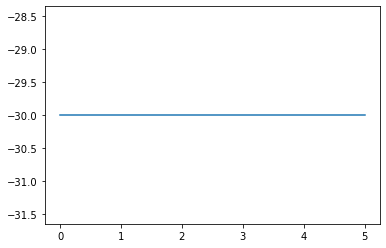

In [12]:
nl_list = [1, 10 , 1]
act_list = [ [leaky_relu, leaky_relu] , [leaky_relu, leaky_relu] ]
model = NN(nl_list, n_itr=5, ETA = .1, activation_func_list=act_list)
model.fit(X)
plt.plot(model.loss_hist)
plt.show()

In [13]:
model.predict(X)

array([[4.12605753e+130, 4.87627327e+130, 4.89833844e+130,
        4.92040361e+130, 4.94246878e+130, 4.96453394e+130,
        4.98659911e+130, 5.00866428e+130, 5.03072945e+130,
        5.05279462e+130, 5.07485979e+130, 5.09692496e+130,
        5.11899013e+130, 5.14105529e+130, 5.16312046e+130,
        5.18518563e+130, 5.20725080e+130, 5.22931597e+130,
        5.25138114e+130, 5.27344631e+130, 5.29551148e+130,
        5.31757664e+130, 5.33964181e+130, 5.36170698e+130,
        5.38377215e+130, 5.40583732e+130, 5.42790249e+130,
        5.44996766e+130, 5.47203283e+130, 5.49409799e+130,
        5.51616316e+130, 5.53822833e+130, 5.56029350e+130,
        5.58235867e+130, 5.60442384e+130, 5.62648901e+130,
        5.64855417e+130, 5.67061934e+130, 5.69268451e+130,
        5.71474968e+130, 5.73681485e+130, 5.75888002e+130,
        5.78094519e+130, 5.80301036e+130, 5.82507552e+130,
        5.84714069e+130, 5.86920586e+130, 5.89127103e+130,
        5.91333620e+130, 5.93540137e+130, 5.95746654e+13

In [14]:
Y = model.predict(X)
Y.shape

(1, 94)

In [15]:
X = keyword
for i in range(len(keyword)):
    X[i] = (X[i] - min(X)) / (max(X) - min(X))
output = Y[0]
S = str()
for i in range(len(Y)):
    Y[0][i] = (Y[0][i] - min(Y[0])) / (max(Y[0]) - min(Y[0])) * (max(keyword) - min(keyword)) + min(keyword)
    S = S + (chr(int(Y[0][i]*len(keyword) + min(keyword))))